In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [35]:


hd_pct = 0.001

strategy_name = '中位断板低吸'
days = 2
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 1,
        "top_cx": 2,
        "only_fx": False,
        "enbale_industry": False,
        "empty_priority": True
      },
      
        ]

filter_count = 0
filter_amount = 9000000
gap = 0
rank_filter = False
sell_use_open = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"{stock_code}-{datekey}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        print(f"{stock_code}-{datekey}")
        last_price_real = -1

    return last_price_real

In [6]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\new_strategy_eval\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,943,2024-09-03,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",...,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:54
1,981,2024-09-04,低吸,中位断板低吸,002806.XSHE,华锋股份,1,"000012.BKDL,000035.BKDL,000027.BKDL","885775.DDBK,885999.DDBK,885662.DDBK,885921.DDB...",980372.ZHBK,...,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:56
2,982,2024-09-04,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,...,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:56
3,1029,2024-09-05,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:44:58
4,1074,2024-09-06,低吸,中位断板低吸,603978.XSHG,深圳新星,1,,,,...,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2334,2025-03-17,低吸,中位断板低吸,002361.XSHE,神剑股份,2,"000038.BKDL,000018.BKDL,000011.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,885650.DDBK,885574.DDB...",980364.ZHBK,...,中位断板低吸,23.05,5.35,37,-71.74,-11.01,63,"{""9A0001"": {""realShortLineScore"": 51.76, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-18 08:00:51
206,2775,2025-03-20,低吸,中位断板低吸,002559.XSHE,亚威股份,1,"000023.BKDL,000018.BKDL,000035.BKDL,000006.BKD...","885743.DDBK,886042.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,...,中位断板低吸,-131.74,15.44,65,-101.70,12.13,71,"{""9A0001"": {""realShortLineScore"": 54.35, ""real...",,2025-03-21 08:00:33
207,2776,2025-03-20,低吸,中位断板低吸,000905.XSHE,厦门港务,2,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,...,中位断板低吸,-131.74,15.44,65,-101.70,12.13,71,"{""9A0001"": {""realShortLineScore"": 54.35, ""real...",,2025-03-21 08:00:33
208,2834,2025-03-21,低吸,中位断板低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,...,中位断板低吸,-4.66,85.21,36,-72.18,10.62,60,"{""9B0002"": {""realShortLineScore"": -44.8, ""real...",,2025-03-21 08:00:59


In [9]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [10]:
combined_df = combined_df.reset_index(drop=True)

In [11]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [12]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
200,1972,2025-03-13,低吸,中位断板低吸,002760.XSHE,凤形股份,1,"000023.BKDL,000013.BKDL","885739.DDBK,885802.DDBK,885700.DDBK",980365.ZHBK,11,6,32,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,1038.82,597.64,0.0,-5.56,24.27,23.29,-1.0,21.87,21.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,31.73,-76.31,22,-37.33,-4.85,47,2025-03-14 08:00:59
201,1973,2025-03-13,低吸,中位断板低吸,605155.XSHG,西大门,2,"000036.BKDL,000026.BKDL,000019.BKDL,000007.BKDL","883436.DDBK,885386.DDBK,885642.DDBK,885965.DDB...","980364.ZHBK,980373.ZHBK",24,57,31,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,151.84,285.93,0.0,-9.16,13.88,13.75,-1.0,13.05,13.05,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,31.73,-76.31,22,-37.33,-4.85,47,2025-03-14 08:00:59
202,2128,2025-03-14,低吸,中位断板低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,3,14,40,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,149.50,282.66,0.0,-0.99,16.05,15.51,-1.0,15.70,15.84,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,38.23,-0.35,29,-54.88,-19.43,53,2025-03-17 08:00:54
203,2129,2025-03-14,低吸,中位断板低吸,603958.XSHG,哈森股份,2,"000010.BKDL,000034.BKDL,000033.BKDL","886100.DDBK,885420.DDBK,885941.DDBK,885784.DDBK",,4,2,-1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,104.22,241.85,0.0,-6.13,18.52,17.76,-1.0,16.69,16.73,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,38.23,-0.35,29,-54.88,-19.43,53,2025-03-17 08:00:54
204,2333,2025-03-17,低吸,中位断板低吸,603206.XSHG,嘉环科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000011.BKD...","886100.DDBK,885919.DDBK,885461.DDBK,885956.DDB...","980753.ZHBK,980376.ZHBK",2,4,20,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,471.70,299.20,0.0,-2.71,21.50,21.01,-1.0,21.01,20.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,23.05,5.35,37,-71.74,-11.01,63,2025-03-18 08:00:51
205,2334,2025-03-17,低吸,中位断板低吸,002361.XSHE,神剑股份,2,"000038.BKDL,000018.BKDL,000011.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,885650.DDBK,885574.DDB...",980364.ZHBK,1,8,42,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0.0,184.22,265.45,0.0,-1.43,6.89,6.84,-1.0,6.79,6.76,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,23.05,5.35,37,-71.74,-11.01,63,2025-03-18 08:00:51
206,2775,2025-03-20,低吸,中位断板低吸,002559.XSHE,亚威股份,1,"000023.BKDL,000018.BKDL,000035.BKDL,000006.BKD...","885743.DDBK,886042.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,100,100,100,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,242.76,252.05,0.0,-1.59,11.74,13.12,-1.0,12.99,12.10,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-131.74,15.44,65,-101.70,12.13,71,2025-03-21 08:00:33
207,2776,2025-03-20,低吸,中位断板低吸,000905.XSHE,厦门港务,2,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,100,100,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,213.69,324.80,0.0,-2.33,8.40,8.05,-1.0,8.13,7.95,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-131.74,15.44,65,-101.70,12.13,71,2025-03-21 08:00:33
208,2834,2025-03-21,低吸,中位断板低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,100,100,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,626.98,502.73,0.0,-6.36,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-4.66,85.

In [13]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 603978.SH 日期 2024-09-06 过滤原因： first_tick_amount 7810800.0
过滤股票 603616.SH 日期 2024-10-10 过滤原因： first_tick_amount 4495988.0
过滤股票 000702.SZ 日期 2024-10-16 过滤原因： first_tick_amount 7962257.0
过滤股票 000510.SZ 日期 2024-10-22 过滤原因： first_tick_amount 5851950.0
过滤股票 002629.SZ 日期 2024-10-25 过滤原因： first_tick_amount 7162038.0
过滤股票 002199.SZ 日期 2024-10-29 过滤原因： first_tick_amount 8631400.0
过滤股票 603028.SH 日期 2024-10-29 过滤原因： first_tick_amount 4476773.0
过滤股票 000953.SZ 日期 2024-10-30 过滤原因： first_tick_amount 7211905.0
过滤股票 002524.SZ 日期 2024-11-14 过滤原因： first_tick_amount 6708309.0
过滤股票 600281.SH 日期 2024-11-15 过滤原因： first_tick_amount 8488532.0
过滤股票 000679.SZ 日期 2024-11-18 过滤原因： first_tick_amount 7632328.0
过滤股票 600191.SH 日期 2025-01-15 过滤原因： first_tick_amount 7124240.0
过滤股票 001380.SZ 日期 2025-02-21 过滤原因： first_tick_amount 5149830.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,943,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,2025-02-15 17:42:54,28394100.0,0.000000,-0.001000,-0.011111,-0.012111
2024-09-04,982,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,2025-02-15 17:43:56,14428245.0,-0.023411,-0.024411,0.016722,0.015722
2024-09-05,1029,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,2025-02-15 17:44:58,11675510.0,0.021012,0.020012,-0.042802,-0.043802
2024-09-06,1075,低吸,中位断板低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",2,1,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.59,211.37,0.0,-5.46,6.75,7.43,-1.0,7.30,8.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,2025-02-15 17:46:06,17896950.0,0.081481,0.080481,0.210370,0.209370
2024-09-19,1380,低吸,中位断板低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1631.86,744.93,0.0,-5.63,1.34,1.56,-1.0,1.57,1.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-36.12,2.15,51,-64.52,-0.66,56,2025-02-15 17:53:33,73509908.0,0.171642,0.170642,0.246269,0.245269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,1972,低吸,中位断板低吸,002760.XSHE,凤形股份,1,"000023.BKDL,000013.BKDL","885739.DDBK,885802.DDBK,885700.DDBK",980365.ZHBK,11,6,32,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,1038.82,597.64,0.0,-5.56,24.27,23.29,-1.0,21.87,21.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,31.73,-76.31,22,-37.33,-4.85,47,2025-03-14 08:00:59,51250667.0,-0.098888,-0.099888,-0.111660,-0.112660
2025-03-14,2128,低吸,中位断板低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,3,14,40,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,149.50,282.66,0.0,-0.99,16.05,15.51,-1.0,15.70,15.84,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,38.23,-0.35,29,-54.88,-19.43,53,2025-03-17 08:00:54,21071980.0,-0.021807,-0.022807,-0.013084,-0.014084
2025-03-17,2333,低吸,中位断板低吸,603206.XSHG,嘉环科技,1,"00001

In [14]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.83' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [15]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-03,1.80,1.78,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-04,14.95,15.20,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-05,12.85,12.30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-06,6.75,8.17,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-19,1.34,1.67,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,24.27,21.56,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-03-14,16.05,15.84,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-03-17,21.50,20.51,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [16]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [17]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,943,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,2025-02-15 17:42:54,28394100.0,0.000000,-0.001000,-0.011111,-0.012111,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.83
2024-09-04,982,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,2025-02-15 17:43:56,14428245.0,-0.023411,-0.024411,0.016722,0.015722,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,15.02
2024-09-05,1029,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,2025-02-15 17:44:58,11675510.0,0.021012,0.020012,-0.042802,-0.043802,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12.86
2024-09-06,1075,低吸,中位断板低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",2,1,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.59,211.37,0.0,-5.46,6.75,7.43,-1.0,7.30,8.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,2025-02-15 17:46:06,17896950.0,0.081481,0.080481,0.210370,0.209370,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.70
2024-09-19,1380,低吸,中位断板低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1631.86,744.93,0.0,-5.63,1.34,1.56,-1.0,1.57,1.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-36.12,2.15,51,-64.52,-0.66,56,2025-02-15 17:53:33,73509908.0,0.171642,0.170642,0.246269,0.245269,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,1783,低吸,中位断板低吸,603108.XSHG,润达医疗,1,"000023.BKDL,000006.BKDL,000037.BKDL,000034.BKD...","886021.DDBK,885739.DDBK,883303.DDBK,886019.DDB...","980345.ZHBK,980378.ZHBK",2,1,45,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,69.38,173.80,0.0

In [18]:
def get_stock_open_close_price(auction_code, date, next_date):
    if '-' in date or '-' in next_date:
        n_date = date.replace('-', '')
        n_next_date = next_date.replace('-', '')
    xtdata.download_history_data(auction_code, period='1d', start_time=n_date, end_time=n_next_date, incrementally = None)
    x1dpdata = xtdata.get_local_data(field_list=[], stock_list=[auction_code], period='1d', start_time=n_date, end_time=n_next_date, count=-1,
               dividend_type='none', fill_data=True)
    df = x1dpdata[auction_code]
    length = len(df)
    if length != 1:
        return -1, -1, -1, -1
    x_data = df.loc[n_date: n_next_date]['open'].astype(float)
    x_data_close = df.loc[n_date: n_next_date]['close'].astype(float)
    start_price = x_data[n_date]
    end_price = x_data[n_next_date]
    close_price = x_data_close[n_date]
    n_close_price = x_data_close[n_next_date]
    return start_price, close_price, end_price, n_close_price

In [19]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from date_utils import get_trade_dates_by_end, get_current_date
last_100_trade_days = get_trade_dates_by_end(get_current_date(), 200)


In [20]:
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    date_key_index = last_100_trade_days.index(date_key)
    after_trade_days = last_100_trade_days[date_key_index+1:date_key_index+11]
    for idx, day in enumerate(after_trade_days):
        open_price, close_price, _, _ = get_stock_open_close_price(stock_code, day, day)
        if open_price > 0:
            combined_df.loc[date_key, f'low_{idx+1}'] = open_price
            combined_df.loc[date_key, f'close_{idx+1}'] = close_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{idx+1}'] = open_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\3217630104.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{idx+1}'] = close_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.77' has dtype incompatible with int64, please explicitly cast to a compatible dtype

In [21]:
combined_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,943,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,2025-02-15 17:42:54,28394100.0,0.000000,-0.001000,-0.011111,-0.012111,1.78,1.80,1.80,1.77,1.72,1.79,1.70,1.70,1.71,1.70,1.67,1.70,1.68,1.68,1.67,1.68,1.66,1.66,1.68,1.67,1.83
2024-09-04,982,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,2025-02-15 17:43:56,14428245.0,-0.023411,-0.024411,0.016722,0.015722,15.20,14.60,14.16,14.96,13.54,14.00,13.39,13.55,13.02,13.26,12.87,12.99,12.39,12.78,12.48,12.34,12.71,12.48,12.51,12.70,15.02
2024-09-05,1029,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,2025-02-15 17:44:58,11675510.0,0.021012,0.020012,-0.042802,-0.043802,12.30,13.12,12.51,12.19,13.76,12.60,15.14,14.63,15.35,14.00,13.82,14.70,13.38,12.90,13.99,13.40,14.31,14.00,15.10,14.20,12.86
2024-09-06,1075,低吸,中位断板低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",2,1,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.59,211.37,0.0,-5.46,6.75,7.43,-1.0,7.30,8.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,2025-02-15 17:46:06,17896950.0,0.081481,0.080481,0.210370,0.209370,8.17,7.30,7.35,8.17,6.62,6.62,6.24,6.35,5.98,6.25,5.91,5.97,6.10,5.93,6.12,6.13,6.18,6.18,6.27,6.15,6.70
2024-09-19,1380,低吸,中位断板低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1631.86,744.93,0.0,-5.63,1.34,1.56,-1.0,1.57,1.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-36.12,2.15,51,-64.52,-0.66,56,2025-02-15 17:53:33,73509908.0,0.171642,0.170642,0.246269,0.245269,1.67,1.57,1.84,1.60,1.88,1.88,2.07,1.80,2.28,2.10,2.31,2.25,2.47,2.35,2.55,2.71,2.30,2.45,2.07,2.07,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20

In [22]:
def caculate_returns(returns_df, row, _print = False, save_to_file=False, file_path='results.txt', extra_info=None):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    cumulative_returns_add = returns_df[row].cumsum()
    cumulative_max_add = cumulative_returns_add.cummax()
    drawdown_add = cumulative_returns_add - cumulative_max_add
    max_drawdown_add = drawdown_add.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    if 'sell_day' in returns_df.columns:
        mean_sell_day = returns_df['sell_day'].mean()
    else:
        mean_sell_day = -1
    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算加和的收益
    sum_return = returns_df[row].sum()

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['加和的最大回撤'] =  max_drawdown_add
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['加和的收益'] = sum_return
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    r['平均卖天数'] = mean_sell_day
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"加和的最大回撤: {max_drawdown_add:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"加和的收益: {sum_return:.2%}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")
    
    if save_to_file:
        with open(file_path, 'a', encoding='utf-8') as f:
            f.write("---------------------------------------------------------------\n")
            f.write(f"策略: {row} , extrainfo:{extra_info}\n")
            for key, value in r.items():
                if isinstance(value, float):
                    if key in ['最大回撤', '加和的最大回撤', '总收益率', '年化收益率', '波动率', '总盈亏', '成功次数', '失败次数', '加和的收益', '平均盈利', '平均亏损', '最大盈利', '最大亏损', '凯利公式最佳仓位', '平均卖天数']:
                        f.write(f"{key}: {value:.2%}\n")
                    elif key in ['夏普比率', '盈亏比', '胜率']:
                        f.write(f"{key}: {value:.2f}\n")
                else:
                    f.write(f"{key}: {value}\n")
            f.write("---------------------------------------------------------------")

    return r

In [23]:
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,943,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,2025-02-15 17:42:54,28394100.0,0.000000,-0.001000,-0.011111,-0.012111,1.78,1.80,1.80,1.77,1.72,1.79,1.70,1.70,1.71,1.70,1.67,1.70,1.68,1.68,1.67,1.68,1.66,1.66,1.68,1.67,1.83
2024-09-04,982,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,2025-02-15 17:43:56,14428245.0,-0.023411,-0.024411,0.016722,0.015722,15.20,14.60,14.16,14.96,13.54,14.00,13.39,13.55,13.02,13.26,12.87,12.99,12.39,12.78,12.48,12.34,12.71,12.48,12.51,12.70,15.02
2024-09-05,1029,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,2025-02-15 17:44:58,11675510.0,0.021012,0.020012,-0.042802,-0.043802,12.30,13.12,12.51,12.19,13.76,12.60,15.14,14.63,15.35,14.00,13.82,14.70,13.38,12.90,13.99,13.40,14.31,14.00,15.10,14.20,12.86
2024-09-06,1075,低吸,中位断板低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",2,1,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.59,211.37,0.0,-5.46,6.75,7.43,-1.0,7.30,8.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,2025-02-15 17:46:06,17896950.0,0.081481,0.080481,0.210370,0.209370,8.17,7.30,7.35,8.17,6.62,6.62,6.24,6.35,5.98,6.25,5.91,5.97,6.10,5.93,6.12,6.13,6.18,6.18,6.27,6.15,6.70
2024-09-19,1380,低吸,中位断板低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1631.86,744.93,0.0,-5.63,1.34,1.56,-1.0,1.57,1.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-36.12,2.15,51,-64.52,-0.66,56,2025-02-15 17:53:33,73509908.0,0.171642,0.170642,0.246269,0.245269,1.67,1.57,1.84,1.60,1.88,1.88,2.07,1.80,2.28,2.10,2.31,2.25,2.47,2.35,2.55,2.71,2.30,2.45,2.07,2.07,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20

In [36]:
import re


sell_days = [2,3,4,5,6,7]
zhisun_lines  = [-0.01, -0.02,-0.03,-0.035,-0.04,-0.045,-0.05,-0.055,-0.06,-0.065,-0.07,-0.075,-0.08,-0.09,-0.10,-0.11,-0.12,-0.13,-0.14,-0.15]
zhiying_lines = [0, 0.01,0.015,0.02,0.025, 0.03,0.035, 0.04,0.045, 0.05,0.055, 0.065,0.08, 0.1]
max_rate = 0
max_rate_info = ""

max_rate_df = pd.DataFrame()

max_return = 0
max_return_info = ""
max_return_df = pd.DataFrame()

max_ykb = 0
max_ykb_info = ""
max_ykb_df = pd.DataFrame()

for sell_day in sell_days:
    for zhisun_line in zhisun_lines:
        for zhiying_line in zhiying_lines:
            extra_info = f'zhisun_{sell_day}_{zhisun_line}_{zhiying_line}'
            ndf = ddwndx.copy()
            ndf = ndf[ndf['real_open'] > 0]
            for date_key, row in ndf.iterrows():
                real_open = row['real_open']
                ndf.at[date_key, 'sy'] = -100
                ndf.at[date_key,'sell_day'] = -1
                for i in range(1, sell_day+1):
                    if sell_use_open:
                        cs = row[f'low_{i}']
                        if cs < 0:
                            continue
                        sy = cs / real_open - 1
                        if sy < zhisun_line:
                            ndf.at[date_key, 'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break
                        if sy > zhiying_line:
                            ndf.at[date_key,'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break

                    cs = row[f'close_{i}']
                    if cs < 0:
                        continue
                    if i == sell_day:
                        cs = row[f'close_{i}']
                        ndf.at[date_key,'sy'] = cs / real_open - 1
                        ndf.at[date_key,'sell_day'] = i
                        break
                    sy = cs / real_open - 1
                    if sy < zhisun_line:
                        ndf.at[date_key, 'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
                    if sy > zhiying_line:
                        ndf.at[date_key,'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
            ndf = ndf[ndf['sy'] > -99]
            if len(ndf) == 0:
                continue
            r= caculate_returns(ndf,'sy',_print = False, save_to_file=True, file_path='results.txt', extra_info=extra_info)
            if r['胜率'] > max_rate:
                max_rate_info = extra_info
                max_rate = max(max_rate, r['胜率'])
                max_rate_df = ndf.copy()
            if r['加和的收益'] > max_return:
                max_return_info = extra_info
                max_return = max(max_return, r['加和的收益'])
                max_return_df = ndf.copy()

            if r['夏普比率'] > max_ykb:
                max_ykb_info = extra_info
                max_ykb = max(max_ykb, r['夏普比率'])
                max_ykb_df = ndf.copy()

print(max_rate_info)
print(max_rate)


print(max_return_info)
print(max_return)


print(max_ykb_info)
print(max_ykb)

zhisun_7_-0.14_0
0.6697247706422018
zhisun_4_-0.055_0.1
3.5900298320268376
zhisun_4_-0.055_0.045
0.27504081917621664


In [55]:
max_ykb_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,943,低吸,中位断板低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-98.75,1.29,72,-59.80,-9.06,43,2025-02-15 17:42:54,28394100.0,0.000000,-0.001000,-0.011111,-0.012111,1.78,1.80,1.80,1.77,1.72,1.79,1.70,1.70,1.71,1.70,1.67,1.70,1.68,1.68,1.67,1.68,1.66,1.66,1.68,1.67,1.83,-0.028322,0.971678,-0.060109,3.0
2024-09-04,982,低吸,中位断板低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.79,2.96,74,-64.50,-4.96,47,2025-02-15 17:43:56,14428245.0,-0.023411,-0.024411,0.016722,0.015722,15.20,14.60,14.16,14.96,13.54,14.00,13.39,13.55,13.02,13.26,12.87,12.99,12.39,12.78,12.48,12.34,12.71,12.48,12.51,12.70,15.02,0.010984,0.982351,-0.057257,2.0
2024-09-05,1029,低吸,中位断板低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-95.78,0.01,75,-69.57,-4.50,47,2025-02-15 17:44:58,11675510.0,0.021012,0.020012,-0.042802,-0.043802,12.30,13.12,12.51,12.19,13.76,12.60,15.14,14.63,15.35,14.00,13.82,14.70,13.38,12.90,13.99,13.40,14.31,14.00,15.10,14.20,12.86,-0.044546,0.938591,0.069984,3.0
2024-09-06,1075,低吸,中位断板低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",2,1,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.59,211.37,0.0,-5.46,6.75,7.43,-1.0,7.30,8.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-74.21,21.57,65,-60.34,-6.98,47,2025-02-15 17:46:06,17896950.0,0.081481,0.080481,0.210370,0.209370,8.17,7.30,7.35,8.17,6.62,6.62,6.24,6.35,5.98,6.25,5.91,5.97,6.10,5.93,6.12,6.13,6.18,6.18,6.27,6.15,6.70,0.218403,1.143582,0.089552,1.0
2024-09-19,1380,低吸,中位断板低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1631.86,744.93,0.0,-5.63,1.34,1.56,-1.0,1.57,1.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-36.12,2.15,51,-64.52,-0.66,56,2025-02-15 17:53:33,73509908.0,0.171642,0.170642,0.246269,0.245269,1.67,1.57,1.84,1.60,1.88,1.88,2.07,1.80,2.28,2.10,2.31,2.25,2.47,2.35,2.55,2.71,2.30,2.45,2.07,2.07,1.37,0.217978,1.392858,0.145985,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:

first = 30000
total_add = 0
all_sys= []
all_firsts = []

for i in range (1, 110):
    total_sy = 0
    for date_key, row in max_ykb_df.tail(i).iterrows():
        sy = row['sy']
        profit = first * sy
        total_sy = total_sy + sy
        first = first + profit
        all_sys.append(first)
        if sy > 0:
            first = first + 2000
            total_add = total_add + 2000
        if sy < 0:
            first = first - 2000
            total_add = total_add - 2000
            if first < 0:
                first = 0
                print(f'爆仓 {date_key}')
        all_firsts.append(profit)
    print(f'第{i}次，从日期{date_key}开始 总收益{total_sy}')

# print(total_add)
# print(all_sys)
# print(all_firsts)

第1次，从日期2025-03-20开始 总收益率0.10271646859083194
第2次，从日期2025-03-20开始 总收益率0.04736763138152955
第3次，从日期2025-03-20开始 总收益率0.12935520902128117
第4次，从日期2025-03-20开始 总收益率0.012991572657644834
第5次，从日期2025-03-20开始 总收益率-0.026561307823868563
第6次，从日期2025-03-20开始 总收益率0.13768287822264302
第7次，从日期2025-03-20开始 总收益率0.0699905705303353
第8次，从日期2025-03-20开始 总收益率-0.02015210132439882
第9次，从日期2025-03-20开始 总收益率0.04420933229498547
第10次，从日期2025-03-20开始 总收益率0.11801748852703597
第11次，从日期2025-03-20开始 总收益率0.0961766148920905
第12次，从日期2025-03-20开始 总收益率0.005027341444270084
第13次，从日期2025-03-20开始 总收益率-0.14342290325393547
爆仓 2025-03-13
爆仓 2025-03-17
第14次，从日期2025-03-20开始 总收益率-0.20508956992060212
爆仓 2025-02-28
爆仓 2025-03-03
爆仓 2025-03-04
爆仓 2025-03-10
爆仓 2025-03-12
爆仓 2025-03-13
爆仓 2025-03-17
第15次，从日期2025-03-20开始 总收益率-0.03576049643817392
爆仓 2025-03-03
爆仓 2025-03-04
爆仓 2025-03-10
爆仓 2025-03-12
爆仓 2025-03-13
爆仓 2025-03-17
第16次，从日期2025-03-20开始 总收益率0.22443367831910765
爆仓 2025-02-24
爆仓 2025-02-28
爆仓 2025-03-03
爆仓 2025-03-04
爆仓 2025-03-10
爆仓 

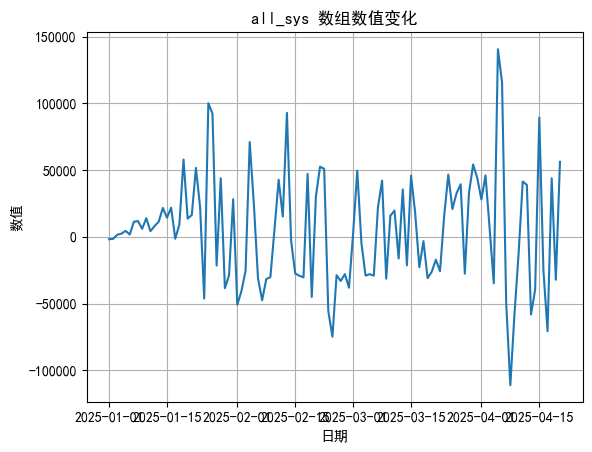

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 all_sys 数组已经定义
# all_sys = [1, 3, 2, 5, 4, 6, 5]
# 生成时间序列
dates = pd.date_range(start='2025-01-01', periods=len(all_firsts))

# 绘制折线图
plt.plot(dates, all_firsts)

# 添加标题和标签
plt.title('all_sys 数组数值变化')
plt.xlabel('日期')
plt.ylabel('数值')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [59]:
max_ykb_df.tail(15)['sy'].cumsum()

date_key
2025-02-26    0.169329
2025-02-27    0.107662
2025-02-28   -0.040788
2025-03-03   -0.131937
2025-03-04   -0.153778
2025-03-05   -0.079970
2025-03-06   -0.015608
2025-03-07   -0.105751
2025-03-10   -0.173443
2025-03-11   -0.009199
2025-03-12   -0.048752
2025-03-13   -0.165116
2025-03-14   -0.083128
2025-03-17   -0.138477
2025-03-20   -0.035760
Name: sy, dtype: float64

In [26]:
max_ykb_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-26,3103,低吸,中位断板低吸,603118.XSHG,共进股份,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,1,37,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,81.42,200.51,0.0,-1.12,12.34,13.31,-1.0,14.64,14.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,67.36,-6.63,13,-9.64,14.33,44,2025-02-28 17:32:13,44380810.0,0.186386,0.185386,0.186386,0.185386,14.64,14.64,14.01,16.10,13.05,13.97,12.22,12.00,12.70,12.38,13.43,12.80,13.03,13.33,12.22,12.91,12.05,12.04,12.27,12.10,12.52,0.169329,1.0
2025-02-27,3152,低吸,中位断板低吸,000536.XSHE,华映科技,1,"000038.BKDL,000006.BKDL,000027.BKDL,000004.BKD...","886021.DDBK,885694.DDBK,885806.DDBK,885800.DDB...",980357.ZHBK,1,1,16,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,81.55,198.54,0.0,-4.21,5.92,5.74,-1.0,5.63,5.91,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,141.33,55.23,9,5.53,1.01,35,2025-02-28 17:33:14,75590005.0,-0.048986,-0.049986,-0.001689,-0.002689,5.91,5.63,5.80,5.72,5.64,5.60,5.73,5.59,6.30,5.73,5.96,6.15,6.02,5.99,6.18,5.88,6.10,6.28,6.10,6.10,6.00,0.050000,5.0
2025-02-28,3711,低吸,中位断板低吸,002522.XSHE,浙江众成,2,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,2,0.0,124.72,222.67,0.0,0.00,6.07,5.46,-1.0,5.22,4.96,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,122.14,-17.15,10,0.37,-3.94,37,2025-03-03 08:01:02,33235071.0,-0.140033,-0.141033,-0.182867,-0.183867,4.96,5.22,5.08,4.93,5.13,5.08,5.26,5.14,5.15,5.26,5.30,5.15,5.25,5.19,5.27,5.33,5.09,5.23,5.13,5.07,6.13,-0.190865,1.0
2025-03-03,146,低吸,中位断板低吸,002406.XSHE,远东传动,2,"000026.BKDL,000006.BKDL,000027.BKDL,000013.BKD...","885743.DDBK,885806.DDBK,885517.DDBK,885783.DDB...",980372.ZHBK,1,2,32,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,127.04,214.64,0.0,-0.40,7.53,6.99,-1.0,6.88,7.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-54.36,-75.23,53,-64.70,-36.35,70,2025-03-04 08:01:03,30195300.0,-0.086321,-0.087321,-0.049137,-0.050137,7.16,6.88,7.16,7.14,7.22,7.14,7.13,7.17,7.08,7.17,7.06,6.97,7.77,7.10,7.48,7.72,7.50,7.48,7.78,7.65,7.57,0.026420,7.0
2025-03-04,530,低吸,中位断板低吸,002298.XSHE,中电鑫龙,1,"000008.BKDL,000018.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885517.DDBK,885919.DDBK,885700.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",1,1,6,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0.0,141.85,203.15,0.0,-9.77,6.37,6.50,-1.0,6.42,6.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-125.60,-48.97,61,-75.70,-3.55,66,2025-03-05 08:01:07,32708039.0,0.007849,0.006849,0.042386,0.041386,6.64,6.42,6.57,6.55,6.25,6.45,6.27,6.26,6.17,6.20,6.33,6.22,6.08,6.29,6.10,6.04,6.06,6.05,6.20,6.10,6.41,0.035881,1.0
2025-03-05,705,低吸,中位断板低吸,603496.XSHG,恒为科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000006.BKD...","885459.DDBK,885517.DDBK,885700.DDBK,885311.DDB...",980366.ZHBK,2,1,31,0,0,1,0,0,0,0,0,0,0,0,0,0,1

In [27]:
max_rate_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-25,3042,低吸,中位断板低吸,600126.XSHG,杭钢股份,2,,,,-1,-1,-1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,125.63,276.40,0.0,-7.69,10.20,12.16,-1.0,12.98,13.38,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,40.81,-29.65,30,-46.88,-13.79,68,2025-02-28 17:31:08,176147880.0,0.272549,0.271549,0.311765,0.310765,13.38,12.98,14.72,12.30,13.25,13.26,11.93,12.00,12.30,11.50,12.37,12.30,12.70,12.59,11.64,12.20,12.14,11.55,13.18,12.00,10.30,0.299029,1.0
2025-02-26,3103,低吸,中位断板低吸,603118.XSHG,共进股份,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,1,37,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,81.42,200.51,0.0,-1.12,12.34,13.31,-1.0,14.64,14.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,67.36,-6.63,13,-9.64,14.33,44,2025-02-28 17:32:13,44380810.0,0.186386,0.185386,0.186386,0.185386,14.64,14.64,14.01,16.10,13.05,13.97,12.22,12.00,12.70,12.38,13.43,12.80,13.03,13.33,12.22,12.91,12.05,12.04,12.27,12.10,12.52,0.169329,1.0
2025-02-27,3152,低吸,中位断板低吸,000536.XSHE,华映科技,1,"000038.BKDL,000006.BKDL,000027.BKDL,000004.BKD...","886021.DDBK,885694.DDBK,885806.DDBK,885800.DDB...",980357.ZHBK,1,1,16,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,81.55,198.54,0.0,-4.21,5.92,5.74,-1.0,5.63,5.91,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,141.33,55.23,9,5.53,1.01,35,2025-02-28 17:33:14,75590005.0,-0.048986,-0.049986,-0.001689,-0.002689,5.91,5.63,5.80,5.72,5.64,5.60,5.73,5.59,6.30,5.73,5.96,6.15,6.02,5.99,6.18,5.88,6.10,6.28,6.10,6.10,6.00,0.050000,5.0
2025-02-28,3711,低吸,中位断板低吸,002522.XSHE,浙江众成,2,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,2,0.0,124.72,222.67,0.0,0.00,6.07,5.46,-1.0,5.22,4.96,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,122.14,-17.15,10,0.37,-3.94,37,2025-03-03 08:01:02,33235071.0,-0.140033,-0.141033,-0.182867,-0.183867,4.96,5.22,5.08,4.93,5.13,5.08,5.26,5.14,5.15,5.26,5.30,5.15,5.25,5.19,5.27,5.33,5.09,5.23,5.13,5.07,6.13,-0.190865,1.0
2025-03-03,146,低吸,中位断板低吸,002406.XSHE,远东传动,2,"000026.BKDL,000006.BKDL,000027.BKDL,000013.BKD...","885743.DDBK,885806.DDBK,885517.DDBK,885783.DDB...",980372.ZHBK,1,2,32,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,127.04,214.64,0.0,-0.40,7.53,6.99,-1.0,6.88,7.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-54.36,-75.23,53,-64.70,-36.35,70,2025-03-04 08:01:03,30195300.0,-0.086321,-0.087321,-0.049137,-0.050137,7.16,6.88,7.16,7.14,7.22,7.14,7.13,7.17,7.08,7.17,7.06,6.97,7.77,7.10,7.48,7.72,7.50,7.48,7.78,7.65,7.57,0.026420,7.0
2025-03-04,530,低吸,中位断板低吸,002298.XSHE,中电鑫龙,1,"000008.BKDL,000018.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885517.DDBK,885919.DDBK,885700.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",1,1,6,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0.0,141.85,203.15,0.0,-9.77,6.37,6.50,-1.0,6.42,6.64,-1.0,-1.0,-1.0,-1.0

In [28]:
max_rate_df.tail(15)['sy'].cumsum()

date_key
2025-02-25    0.299029
2025-02-26    0.468358
2025-02-27    0.518358
2025-02-28    0.327494
2025-03-03    0.353914
2025-03-04    0.389795
2025-03-05    0.463603
2025-03-06    0.673598
2025-03-07    0.633391
2025-03-10    0.589545
2025-03-11    0.709457
2025-03-12    0.711177
2025-03-13    0.560470
2025-03-14    0.642458
2025-03-20    0.669622
Name: sy, dtype: float64

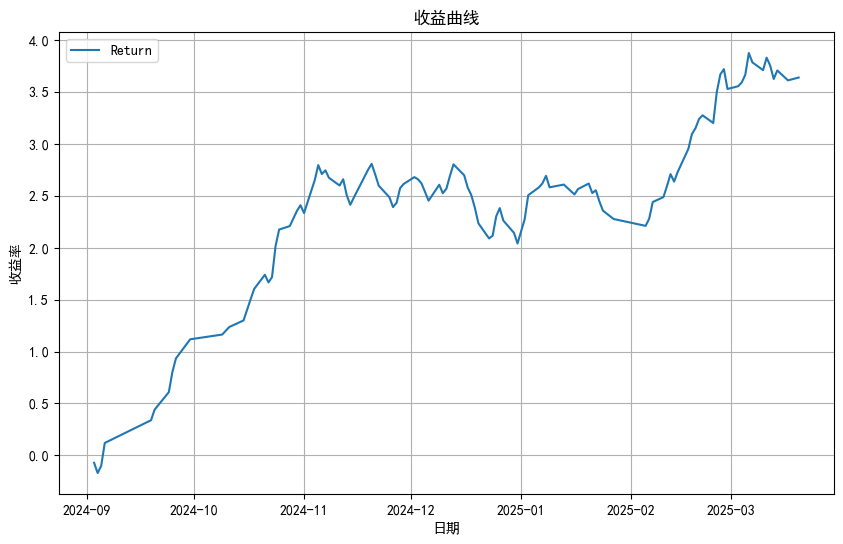

In [29]:
max_return_df['cumulative_returns'] = max_return_df['sy'].cumsum()
plot(max_return_df, 'cumulative_returns')

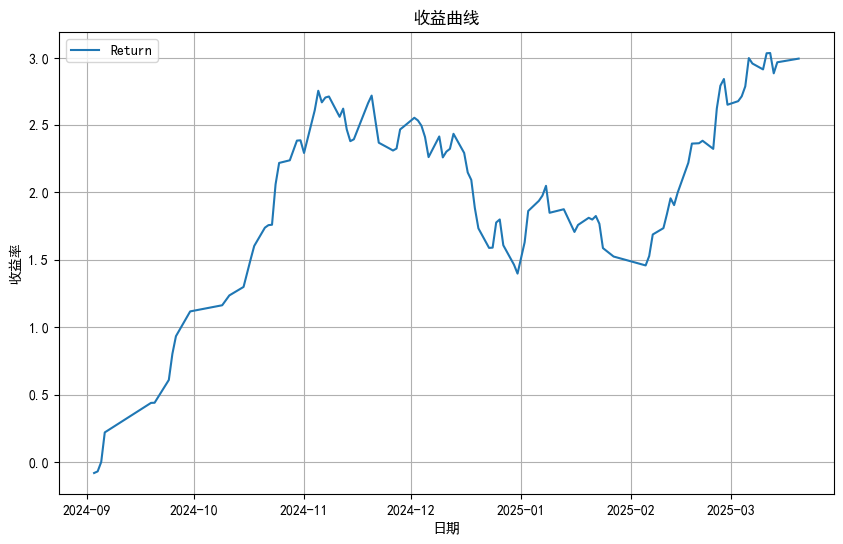

In [30]:
max_rate_df['cumulative_returns'] = max_rate_df['sy'].cumsum()
plot(max_rate_df, 'cumulative_returns')

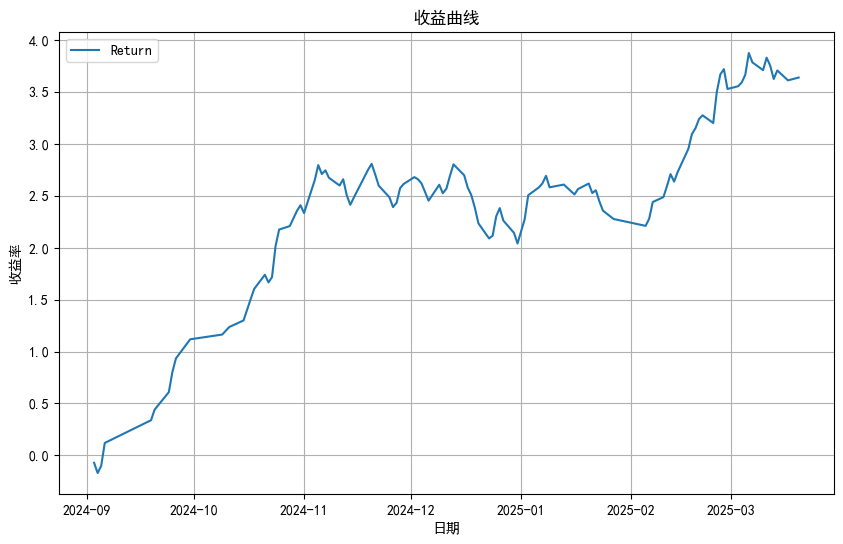

In [31]:
max_ykb_df['cumulative_returns'] = max_ykb_df['sy'].cumsum()
plot(max_ykb_df, 'cumulative_returns')

In [32]:
max_ykb_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-26,3103,低吸,中位断板低吸,603118.XSHG,共进股份,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,1,37,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,81.42,200.51,0.0,-1.12,12.34,13.31,-1.0,14.64,14.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,67.36,-6.63,13,-9.64,14.33,44,2025-02-28 17:32:13,44380810.0,0.186386,0.185386,0.186386,0.185386,14.64,14.64,14.01,16.10,13.05,13.97,12.22,12.00,12.70,12.38,13.43,12.80,13.03,13.33,12.22,12.91,12.05,12.04,12.27,12.10,12.52,0.169329,1.0,3.667818
2025-02-27,3152,低吸,中位断板低吸,000536.XSHE,华映科技,1,"000038.BKDL,000006.BKDL,000027.BKDL,000004.BKD...","886021.DDBK,885694.DDBK,885806.DDBK,885800.DDB...",980357.ZHBK,1,1,16,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,81.55,198.54,0.0,-4.21,5.92,5.74,-1.0,5.63,5.91,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,141.33,55.23,9,5.53,1.01,35,2025-02-28 17:33:14,75590005.0,-0.048986,-0.049986,-0.001689,-0.002689,5.91,5.63,5.80,5.72,5.64,5.60,5.73,5.59,6.30,5.73,5.96,6.15,6.02,5.99,6.18,5.88,6.10,6.28,6.10,6.10,6.00,0.050000,5.0,3.717818
2025-02-28,3711,低吸,中位断板低吸,002522.XSHE,浙江众成,2,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,2,0.0,124.72,222.67,0.0,0.00,6.07,5.46,-1.0,5.22,4.96,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,122.14,-17.15,10,0.37,-3.94,37,2025-03-03 08:01:02,33235071.0,-0.140033,-0.141033,-0.182867,-0.183867,4.96,5.22,5.08,4.93,5.13,5.08,5.26,5.14,5.15,5.26,5.30,5.15,5.25,5.19,5.27,5.33,5.09,5.23,5.13,5.07,6.13,-0.190865,1.0,3.526953
2025-03-03,146,低吸,中位断板低吸,002406.XSHE,远东传动,2,"000026.BKDL,000006.BKDL,000027.BKDL,000013.BKD...","885743.DDBK,885806.DDBK,885517.DDBK,885783.DDB...",980372.ZHBK,1,2,32,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,127.04,214.64,0.0,-0.40,7.53,6.99,-1.0,6.88,7.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-54.36,-75.23,53,-64.70,-36.35,70,2025-03-04 08:01:03,30195300.0,-0.086321,-0.087321,-0.049137,-0.050137,7.16,6.88,7.16,7.14,7.22,7.14,7.13,7.17,7.08,7.17,7.06,6.97,7.77,7.10,7.48,7.72,7.50,7.48,7.78,7.65,7.57,0.026420,7.0,3.553373
2025-03-04,530,低吸,中位断板低吸,002298.XSHE,中电鑫龙,1,"000008.BKDL,000018.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885517.DDBK,885919.DDBK,885700.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",1,1,6,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0.0,141.85,203.15,0.0,-9.77,6.37,6.50,-1.0,6.42,6.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0042,中位断板低吸,-125.60,-48.97,61,-75.70,-3.55,66,2025-03-05 08:01:07,32708039.0,0.007849,0.006849,0.042386,0.041386,6.64,6.42,6.57,6.55,6.25,6.45,6.27,6.26,6.17,6.20,6.33,6.22,6.08,6.29,6.10,6.04,6.06,6.05,6.20,6.10,6.41,0.035881,1.0,3.589255
2025-03-05,705,低吸,中位断板低吸,603496.XSHG,恒为科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000006.BKD...","885459.DDBK,885517.DDBK,885700.D

In [33]:
ddwndx['r_1return'] = ddwndx['close_1'] / ddwndx['real_open'] - 1
ddwndx['r_1return'] = ddwndx['r_1return']-0.001
ddwndx['cumulative_1returns'] = (1 + ddwndx['r_1return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_1return', _print=True, save_to_file=True)
print('-----------------------------------------------------')

return:
最大回撤: -71.98%
加和的最大回撤: -112.18%
夏普比率: 0.23
总收益率: 811.74%
年化收益率: 1771.07%
波动率: 11.51%
总盈亏: 814.57%
成功次数: 60
失败次数: 50
加和的收益: 291.75%
总天数: 110
总交易次数: 110
交易频率: 100.00%
胜率: 54.55%
平均盈利: 10.96%
平均亏损: -7.32%
最大盈利: 31.48%
最大亏损: -19.19%
盈亏比: 1.50
凯利公式最佳仓位: 24.20%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\1323985323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_1return'] = ddwndx['close_1'] / ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\1323985323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_1return'] = ddwndx['r_1return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31144\1323985323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [34]:
ddwndx2 = ddwndx.copy()
ddwndx2 = ddwndx2[ddwndx2['close_2'] > 0]
ddwndx2['r_2return'] = ddwndx2['close_2'] / ddwndx2['real_open'] - 1
ddwndx2['r_2return'] = ddwndx2['r_2return']-0.001

ddwndx2['cumulative_2returns'] = (1 + ddwndx2['r_2return']).cumprod()
print("return:")
caculate_returns_n(ddwndx2, 'r_2return', _print=True)
print('-----------------------------------------------------')

return:


NameError: name 'caculate_returns_n' is not defined

In [ ]:
def caculate_returns_n(returns_df, row, n=1000, _print=False):
    r = {}
    # 计算每天的收益金额
    daily_profit = n * returns_df[row]
    # 计算累计收益金额
    cumulative_profit = daily_profit.cumsum()

    # 计算最大回撤
    cumulative_max = cumulative_profit.cummax()
    drawdown = (cumulative_profit - cumulative_max)
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (daily_profit.mean() - risk_free_rate) / daily_profit.std()

    # 计算总收益率
    total_return = cumulative_profit.iloc[-1] / n

    # 计算波动率
    volatility = daily_profit.std()

    # 计算总盈亏
    total_profit_loss = cumulative_profit.iloc[-1]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = daily_profit[daily_profit > 0].count()
    losing_trades = daily_profit[daily_profit < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = daily_profit[daily_profit > 0].mean() if profitable_trades > 0 else 0
    average_loss = daily_profit[daily_profit < 0].mean() if losing_trades > 0 else 0
    max_profit = daily_profit.max()
    max_loss = daily_profit.min()
    total_trades = profitable_trades + losing_trades
    total_times = daily_profit.count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] = max_drawdown / n
    r['夏普比率'] = sharpe_ratio
    r['总收益率'] = total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown / n:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2f}")
        print(f"总盈亏: {total_profit_loss:.2f}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2f}")
        print(f"平均亏损: {average_loss:.2f}")
        print(f"最大盈利: {max_profit:.2f}")
        print(f"最大亏损: {max_loss:.2f}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:
i=3
ddwndx_i = ddwndx.copy()
# 筛选出 close_i 大于 0 的数据
ddwndx_i = ddwndx_i[ddwndx_i[f'close_{i}'] > 0]
# 计算 r_ireturn
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'close_{i}'] / ddwndx_i['real_open'] - 1
# 扣除手续费
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'r_{i}return'] - 0.001

print(len(ddwndx_i[ddwndx_i[f'r_{i}return'] > 0]))
# 计算累计收益
ddwndx_i[f'cumulative_{i}returns'] = (1 + ddwndx_i[f'r_{i}return']).cumprod()
print(f"return_{i}:")
caculate_returns_n(ddwndx_i, f'r_{i}return', _print=True)
print('-----------------------------------------------------')

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

In [ ]:
ddwndx.tail(20)

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
